In [ ]:
11

11

## packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/mydrive/')

Drive already mounted at /content/mydrive/; to attempt to forcibly remount, call drive.mount("/content/mydrive/", force_remount=True).


## csvs

In [ ]:
train = pd.read_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/given-datasets/train.csv')
train.head(1)

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental
0,2018-01-01,NaN,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950


In [ ]:
test = pd.read_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/given-datasets/test.csv')
test.head(1)

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max
0,2021-01-01,NaN,-4.2,1.6,-9.8,30.0,17.0,64.0,6.5,67.7,2.0,4.1


In [ ]:
# 프로젝트의 목표 : 따릉이 대여량 예측
submission = pd.read_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/given-datasets/sample_submission.csv')
submission.head(1)

,date,rental
0,2021-01-01,0


## preprocessing


### preprocessing of column date using pd.Series.dt

#### pandas.to_datetime
- https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html

In [ ]:
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d')

#### pandas.Series.dt.year
- https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.year.html

In [ ]:
# add year column to train
# return year entries as int64
train['year'] = train['date'].dt.year 

#### pandas.Series.dt.month
- https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.month.html

In [ ]:
# add month column to train
# return month entries as int64
train['month'] = train['date'].dt.month 

#### pandas.Series.dt.day
- https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.day.html

In [ ]:
# add day column to train
# return day entries as int64
train['day'] = train['date'].dt.day

#### pandas.Series.dt.dayofweek
-  https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.dayofweek.html#pandas-series-dt-dayofweek
- Monday=0, Sunday=6

In [ ]:
# return day of week entries as int64
train['day_of_week'] = train['date'].dt.dayofweek

#### calendar
-  http://kgp.kaist.ac.kr/moodle/calendar/view.php?view=month&time=1514732400&lang=ko

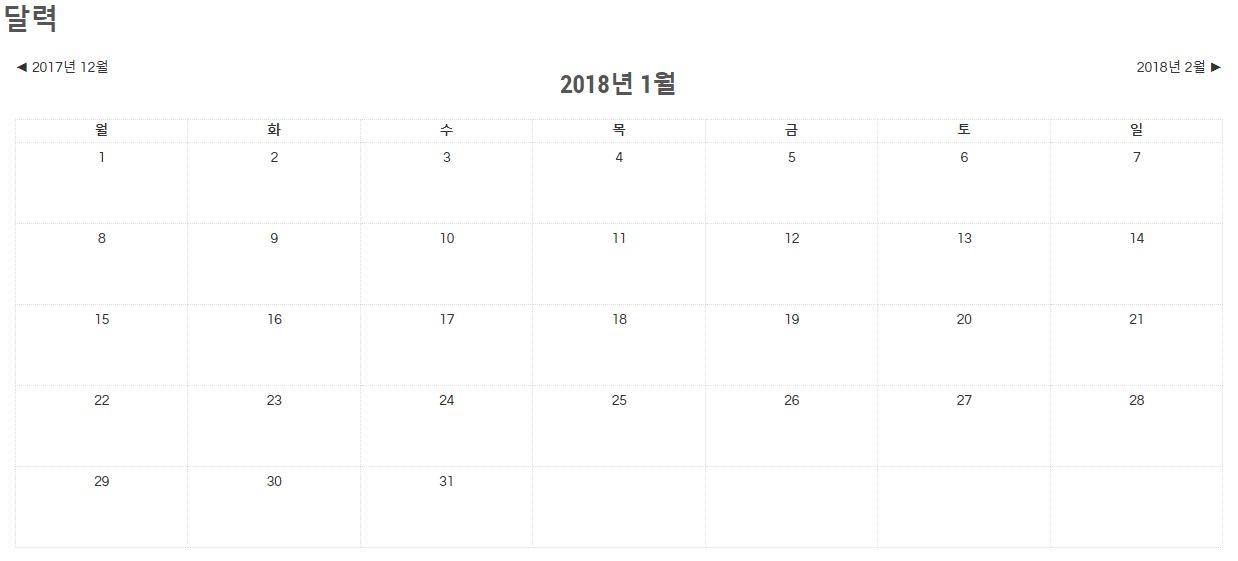

In [ ]:
train.head(3)

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,year,month,day,day_of_week
0,2018-01-01,NaN,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950,2018,1,1,0
1,2018-01-02,NaN,-1.8,1.8,-4.3,36.0,22.0,42.0,7.9,82.3,1.8,4.9,7136,2018,1,2,1
2,2018-01-03,NaN,-4.7,-0.4,-7.1,31.0,19.0,42.3,8.6,88.7,2.2,3.5,7156,2018,1,3,2


## 기상청에서는 0.1 단위로 강수량을 측정해서 0.1 이하로 비가 내리면 0으로 표시된다. 따라서 0.1 이하로 표시된 데이터는 0으로 바꿀 필요가 있다.

### preprocessing of missing values

In [ ]:
# remove entire sample with PM10 and PM2.5 missing values
train.dropna(axis=0, subset=['PM10', 'PM2.5'], inplace=True)

# load imputer
imp_zero = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)

# replace sunshine_sum and precipitaion missing values with 0 and also drop out column date
imputed_train = pd.DataFrame(imp_zero.fit_transform(train.select_dtypes(exclude=['datetime64[ns]'])))

# imputation removed column names; put them back
imputed_train.columns = ['precipitation',
                         'temp_mean',
                         'temp_highest',
                         'temp_lowest',
                         'PM10',
                         'PM2.5',
                         'humidity',
                         'sunshine_sum',
                         'sunshine_rate',
                         'wind_mean',
                         'wind_max',
                         'rental',
                         'year',
                         'month', 
                         'day',
                         'day_of_week']


# imputer changed year, month, day, and day_of_week to float64
# rental column은 imputer에 들어갔다가 나오면 float으로 전환되어 있다.
# 따라서 이 cell 앞에서 train['rental] = train['rental].astype(float)를 굳이할 필요가 없다.
imputed_train['year'] = imputed_train['year'].astype(int)
imputed_train['month'] = imputed_train['month'].astype(int)
imputed_train['day'] = imputed_train['day'].astype(int)
imputed_train['day_of_week'] = imputed_train['day_of_week'].astype(int)

# rename imputed_train as train for convenience
train = imputed_train

### test set

In [ ]:
# 1 
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d')

# 2 
test['year'] = test['date'].dt.year 


# 3
test['month'] = test['date'].dt.month 


# 4
test['day'] = test['date'].dt.day

# 5
test['day_of_week'] = test['date'].dt.dayofweek

# 4, 5
imputed_test = pd.DataFrame(imp_zero.fit_transform(test.select_dtypes(exclude=['datetime64[ns]'])))
imputed_test.columns = ['precipitation',
                         'temp_mean',
                         'temp_highest',
                         'temp_lowest',
                         'PM10',
                         'PM2.5',
                         'humidity',
                         'sunshine_sum',
                         'sunshine_rate',
                         'wind_mean',
                         'wind_max',
                         'year',
                         'month', 
                         'day',
                         'day_of_week']


# 6
imputed_test['year'] = imputed_test['year'].astype(int)
imputed_test['month'] = imputed_test['month'].astype(int)
imputed_test['day'] = imputed_test['day'].astype(int)
imputed_test['day_of_week'] = imputed_test['day_of_week'].astype(int)


# 7
test = imputed_test

### final datasets

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026 entries, 0 to 1025
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   precipitation  1026 non-null   float64
 1   temp_mean      1026 non-null   float64
 2   temp_highest   1026 non-null   float64
 3   temp_lowest    1026 non-null   float64
 4   PM10           1026 non-null   float64
 5   PM2.5          1026 non-null   float64
 6   humidity       1026 non-null   float64
 7   sunshine_sum   1026 non-null   float64
 8   sunshine_rate  1026 non-null   float64
 9   wind_mean      1026 non-null   float64
 10  wind_max       1026 non-null   float64
 11  rental         1026 non-null   float64
 12  year           1026 non-null   int64  
 13  month          1026 non-null   int64  
 14  day            1026 non-null   int64  
 15  day_of_week    1026 non-null   int64  
dtypes: float64(12), int64(4)
memory usage: 128.4 KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   precipitation  365 non-null    float64
 1   temp_mean      365 non-null    float64
 2   temp_highest   365 non-null    float64
 3   temp_lowest    365 non-null    float64
 4   PM10           365 non-null    float64
 5   PM2.5          365 non-null    float64
 6   humidity       365 non-null    float64
 7   sunshine_sum   365 non-null    float64
 8   sunshine_rate  365 non-null    float64
 9   wind_mean      365 non-null    float64
 10  wind_max       365 non-null    float64
 11  year           365 non-null    int64  
 12  month          365 non-null    int64  
 13  day            365 non-null    int64  
 14  day_of_week    365 non-null    int64  
dtypes: float64(11), int64(4)
memory usage: 42.9 KB


## validation models

In [ ]:
y = train.rental
X = train.drop('rental', axis=1)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, 
                                                      y,
                                                      train_size=0.8,
                                                      test_size=0.2,
                                                      random_state=0,
                                                      shuffle=True)

In [ ]:
# define models
model_1 = RandomForestRegressor(n_estimators=50, random_state=0)
model_2 = RandomForestRegressor(n_estimators=100, random_state=0)
model_3 = RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=0)
model_4 = RandomForestRegressor(n_estimators=200, min_samples_split=20, random_state=0)
model_5 = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=0)
model_6 = XGBRegressor(n_estimators=500)

model_7 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(model_7,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

models = [model_1, model_2, model_3, model_4, model_5, model_6]

def score_model(model, X_t=X_train, X_v=X_valid, y_t=y_train, y_v=y_valid):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds)

for i in range(0, len(models)):
    mae = score_model(models[i])
    print('model %d MAE : %d' %(i+1, mae))

xgb_grid.fit(X_train, y_train)
print(xgb_grid.best_params_)

model 1 MAE : 5372
model 2 MAE : 5319
model 3 MAE : 5385
model 4 MAE : 5844
model 5 MAE : 6112
[17:17:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
model 6 MAE : 4829
Fitting 2 folds for each of 9 candidates, totalling 18 fits
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [ ]:
model_8 = XGBRegressor(colsample_bytree=0.7,
                       learning_rate=0.03,
                       max_depth=5,
                       min_child_weight=4,
                       n_estimators=500,
                       nthread=4,
                       objective='reg:linear',
                       silent=1,
                       subsample=0.7)
model_8.fit(X_train, y_train)
preds = model_8.predict(X_valid)
mae = mean_absolute_error(y_valid, preds)
print('model 8 MAE : ', mae)

model 8 MAE :  4441.280934750455


## test model

In [ ]:
train = shuffle(train)
train.head(3)

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,year,month,day,day_of_week
1024,0.0,-10.9,-6.2,-12.9,39.0,15.0,55.5,8.3,86.5,4.1,6.2,22488.0,2020,12,30,2
558,0.0,19.5,26.0,13.6,27.0,11.0,46.5,10.2,82.9,1.9,4.3,91554.0,2019,9,19,3
321,0.0,1.4,5.3,-2.4,158.0,112.0,68.6,0.4,4.1,0.9,2.5,14818.0,2019,1,14,0


In [ ]:
y = train.rental
X = train.drop('rental', axis=1)

In [ ]:
test_model = RandomForestRegressor(n_estimators=100, random_state=0)
test_model.fit(X, y)
submission['rental'] = test_model.predict(test)

In [ ]:
test_model = XGBRegressor(colsample_bytree=0.7,
                       learning_rate=0.03,
                       max_depth=5,
                       min_child_weight=4,
                       n_estimators=500,
                       nthread=4,
                       objective='reg:linear',
                       silent=1,
                       subsample=0.7)
test_model.fit(X, y)
submission['rental'] = test_model.predict(test)

In [ ]:
submission.to_csv('/content/mydrive/MyDrive/seoul-bike-rental-prediction/submissions/submission-2022-06-16-ik.csv', index=False)

## submission result
- day_of_week feature를 추가하면 성능이 향상된다.


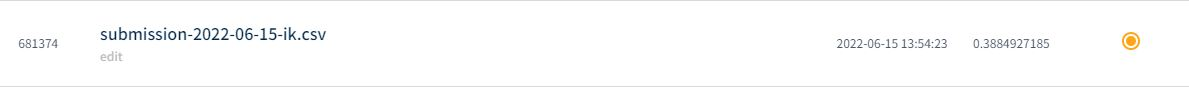

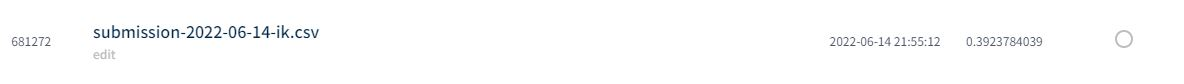